# 나랑 닮은 연예인은 누굴까?
Face Embedding Vector를 이용해 나와 닮은 연예인을 찾아보자!
- **데이터 크롤링**을 이용해 최대한 많은 연예인 이미지 확보([대한민국 연예인 명단](https://namu.wiki/w/%EC%97%B0%EC%98%88%EC%9D%B8/%EB%B3%B8%EB%AA%85%20%EB%B0%8F%20%EC%98%88%EB%AA%85))
- 약 1400명의 연예인의 이미지를 이용하여 닮은 연예인 찾기 실시
- 번외로 만화 캐릭터를 이용하여 닮은 만화 캐릭터 찾기 실시

## 목차

### 연예인 데이터
> **크롤링을 통해 수집한 연예인 데이터를 이용하여 닮은 연예인 찾기**
1. 데이터 수집
  - **여러 조건(썬글라스착용 여부, 마스크착용 여부, 얼굴 회전각도, 이미지 사이즈 등)**
  - Goole 이미지에서 수집
1. 데이터 확인
  - 데이터 점검
2. 얼굴 탐지
  - **얼굴 부분 자르기(Crop)**
  - **탐지 실패 시 Model 변경 후 재시도(CNN Model)**
3. 얼굴 임베딩
  - **Face Embedding Vector 추출**
  - **탐지 실패 시 Model 변경 후 재시도(CNN Model)**
  - **연예인 얼굴 임베딩 결과를 pickle로 저장**
3. 얼굴 임베딩 결과 전처리
4. 연예인 목록 시각화
4. 얼굴 임베딩 거리 측정
  - **L2 Distance를 이용해 얼굴 유사도 측정**
5. 결과 확인
  - 닮은 연예인 시각화
6. tSNE 시각화

<hr>

### 만화 캐릭터 데이터
> **크롤링을 통해 수집한 만화 캐릭터를 이용하여 닮은 캐릭터 찾기**

# 데이터 수집
- 나무위키에서 모든 연예인 이름 크롤링 [연예인 목록](https://namu.wiki/w/%EC%97%B0%EC%98%88%EC%9D%B8/%EB%B3%B8%EB%AA%85%20%EB%B0%8F%20%EC%98%88%EB%AA%85)
- 다양한 조건에 적합한 데이터 Google 이미지에서 수집
- 크롤링 코드는 다음과 같다.<br>
(https://github.com/gjustin40/Python-Web-Crawling/blob/master/Web_Crawling_Project10_Celebrity_Collection.ipynb)

In [154]:
import os
import re

import glob
import pickle
import numpy as np
import pandas as pd

from PIL import Image
from tqdm.notebook import tqdm_notebook

import face_recognition as fr

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

np.random.seed(50)

pont_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
fontprop = fm.FontProperties(fname=pont_path, size=18)

# 데이터 확인
외부에서 얻은 이미지이기 떄문에 모두 정상적인 데이터인지 확인
> **간단하게 사진을 불러오는 함수를 이용해 정상적으로 로드가 되었는지 확인<br>
문제가 있는 파일은 해당 파일의 경로를 출력**

### 데이터 점검 및 개수 확인
예외처리를 통해 이상이 있는 데이터 확인
- 연예인 약 1400명
- 인식률을 높이기 위해 몇 명의 연예인은 2개의 이미지 사용
> **각 이미지 파일의 이름은 (예명 본명.jpg)로 구성되어 있음**

In [155]:
image_dir = os.getenv('HOME') + '/aiffel/face_embedding/celebrity_google/*.jpg'
image_list = glob.glob(image_dir)

print(f'Number of Images :', len(image_list))

for i, image_path in enumerate(image_list):
    try:
        image = fr.load_image_file(image_path) # 이미지를 불러오는 함수를 이용해 실패 시 이상이 있는 데이터로 취급 
    except:
        print(f'{image_path} File Error')

print('All images are loaded')

Number of Images : 2707
All images are loaded


### 데이터 시각화

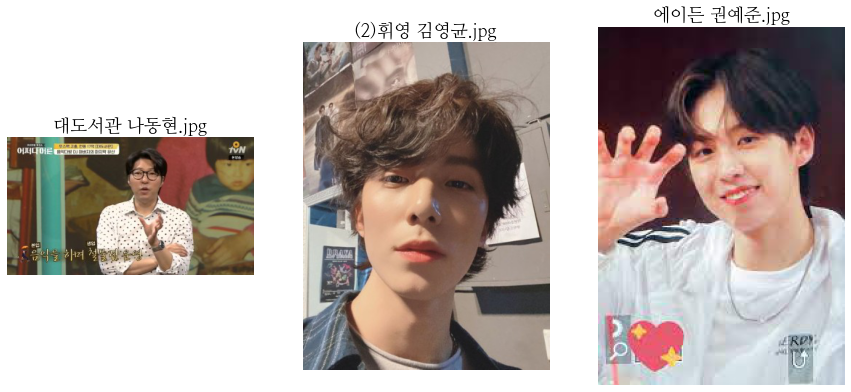

In [156]:
plt.figure(figsize=(15, 15))
for i, image_path in enumerate(image_list[::1000]):
    file_name = image_path.split('/')[-1]
    plt.subplot(1,3,i+1)
    plt.imshow(np.array(Image.open(image_path)))
    plt.title(file_name, fontproperties=fontprop)
    plt.axis('off')

# 얼굴 탐지
이후에 계속 사용하기 위해 함수로 정의
- ```get_name()``` : 파일명에서 이름만 추출하는 함수(예명 본명)
- ```get_cropped_face()``` : 이미지에서 얼굴만 추출하는 함수(HOG와 CNN 두 가지 모델 이용 가능)

In [157]:
# 파일명으로부터 연예인 이름 추출
def get_name(image_path):
    file_name = image_path.split('/')[-1]
    name = file_name.split('.')[0]
    
    return name

# 이미지에서 얼굴을 추출하는 함수
def get_cropped_face(image, model='hog'):                 # model은 HOG와 CNN 두 가지 가능
    face_location = fr.face_locations(image, model=model) # 얼굴 탐지 함수
    top, right, bottom, left = face_location[0]           # 탐지된 box 좌표
    cropped_image = image[top:bottom, left:right]         # 좌표를 이용해 이미지 내에서 해당 area만 추출
    
    return cropped_image

### 얼굴 자르기(Crop)
얼굴 인식과 자르기를 동시에 진행

- 얼굴을 인식하지 못한 사진은 따로 저장한 후 전처리
- **전처리를 진행한 후에도 얼굴을 식별하지 못하면 데이터에서 삭제**
> **한 번 얼굴 추출에 실패한 연예인은 추후에 다른 이미지로 다시 크롤링**

In [141]:
image_dir = os.getenv('HOME') + '/aiffel/face_embedding/celebrity_google/*.jpg'
image_list = glob.glob(image_dir)

cropped_image_dict = {}    # crop된 이미지 모음
failed_image_dict = {}     # 실패한 연예인 이름, path 모음(이후에 다른 사진으로 다시 크롤링)
for image_path in tqdm_notebook(image_list):
    try:
        name = get_name(image_path)                   # 이미지 파일로부터 연예인 이름(예명 본명) 추출
        image = fr.load_image_file(image_path)        # 이미지 불러오기

        cropped_face = get_cropped_face(image)        # 얼굴 추출
        cropped_image_dict[name] = cropped_face       # 추출된 얼굴 저장
    except:
        failed_image_dict[name] = image_path # 실패한 연예인의 이름과 image_path 저장(추후에 크롤링을 위해)
        
print(f'{len(failed_image_dict)} Error image exist')

  0%|          | 0/2707 [00:00<?, ?it/s]

3 Error image exist


### 얼굴 미식별 이미지 확인
```face_locations()```함수의 모델을 CNN으로 변경 후 시도
- 대체 사진이 없어서 추가로 이미지를 구하지 못하는 연예인
> **CNN 모델로도 식별하지 못하면 삭제**

In [142]:
for name, data in failed_image_dict.items():
    try:
        cropped_image = get_cropped_face(image, model='cnn')   # 얼굴 추출 시 model을 CNN방식으로 설정
        cropped_image_dict[name] = cropped_image
        print(f"CNN model recognized {name}'s face!")
    except:
        print(f'{name} will be removed')      

CNN model recognized TRIPPY DOG 김정훈's face!
CNN model recognized 한그루 민한그루's face!
CNN model recognized 계피 임수진's face!


### Cropped Image 저장

In [143]:
with open('face_cropped_full.pkl', 'wb') as f:     # Crop 결과 pickle 자료형으로 저장
    pickle.dump(cropped_image_dict, f)
    
with open('face_cropped_full.pkl', 'rb') as f:     # 저장된 Crop 이미지 불러오기
    cropped_image_dict = pickle.load(f)
    
print('Number of Celebrities :', len(cropped_image_dict))

Number of Celebrities : 2698


### 얼굴 탐지 결과 시각화

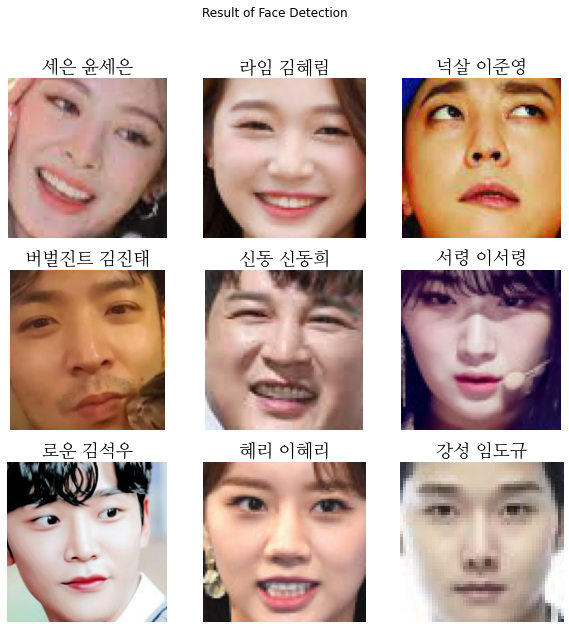

In [7]:
# 파일의 제목을 깔끔하게 정리하는 함수
def get_korean(name):
    hangul = re.compile('[ ㄱ-ㅣ가-힣]+')
    return hangul.findall(name)[0]

sample_list = list(cropped_image_dict.keys())[80:89] # 시각화를 위해 랜덤하게 얼굴 추출

plt.figure(figsize=(10,10))
plt.suptitle('Result of Face Detection')
for i, sample in enumerate(sample_list):
    plt.subplot(3,3,i+1)
    plt.imshow(cropped_image_dict[sample])
    plt.title(get_korean(sample), fontproperties=fontprop)
    plt.axis('off')

# 얼굴 임베딩
FaceNet모델을 이용해 얼굴을 Embedding
- 임베딩 실패 시 CNN 모델로 변경한 후 재시도
- CNN 모델로도 실패 시 데이터에서 제외
- ```tqdm_notebook()``` : 현재 반복문의 진행상태 확인하는 함수
> **얼굴 탐지에서는 실패한 경우 따로 처리를 해줬지만, 임베딩은 같이 진행**

In [8]:
embedding_dict = {} # 임베딩 결과 모음
fail_dict = {}      # 임베딩 실패한 연예인 모음
for data in tqdm_notebook(cropped_image_dict.items()):          # tqdm_notebook : 반복문의 진행상태 확인
    name, face = data
    embedding = fr.face_encodings(face)                          # 얼굴 임베딩(feature 추출)
    
    if len(embedding) >= 1:                                      # out of range 오류를 방지하기 위해 조건문 추가
        embedding_dict[name] = embedding[0]                       
    else:
        embedding_retry = fr.face_encodings(face, model='cnn')   # Embedding 실패 시 CNN모델로 재시도
        
        if len(embedding_retry) >= 1:                            # CNN모델로 Embedding 성공 시 dict에 추가
            embedding_dict[name] = embedding_retry[0]
            print(f'{name} Embedding Successed!')
        else:
            print(f'{name} Embedding Fail!')
            fail_dict[name] = face

  0%|          | 0/2698 [00:00<?, ?it/s]

### 연예인 얼굴 임베딩 결과 저장하기
간단하게 재사용할 수 있도록 pickle로 저장
- 매번 위 과정을 거쳐야 하는 번거로움을 없애기 위해 저장
- **다른 서비스에서 임베딩 결과만 활용하면 편리하기 때문에**
> **불러오기를 통해 여러 얼굴을 테스트할 때 위 과정 생략할 수 있도록 조치**

In [80]:
with open('face_embedding_full.pkl', 'wb') as f:     # 임베딩 결과 pickle 자료형으로 저장
    pickle.dump(embedding_dict, f)
    
with open('face_embedding_full.pkl', 'rb') as f:     # 저장된 임베딩 결과 불러오기
    embedding_dict = pickle.load(f)
    
print('Number of Celebrities :', len(embedding_dict))

Number of Celebrities : 2304


# 임베딩 결과 전처리
데이터를 수집하는 과정에서 같은 이미지가 포함
> **pandas 기능을 이용해 임베딩 결과가 중복된 데이터는 삭제**

### 임베딩 데이터 확인

In [11]:
df_embedding = pd.DataFrame(embedding_dict).T          # Column과 index를 바꾼다
df_embedding[df_embedding.duplicated()].head(4)        # 중복 데이터 출력

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
고결 고민수,-0.067328,0.080695,0.002384,-0.087879,-0.167603,0.002819,-0.086057,-0.129716,0.140557,-0.117970,...,0.056323,0.088036,-0.003793,-0.042764,-0.240406,-0.076464,0.138894,-0.036191,0.126483,0.053013
택연 옥택연,-0.061826,0.083952,0.021491,-0.081246,-0.160380,-0.034421,-0.064440,-0.132039,0.158612,-0.093641,...,0.135342,0.024799,-0.001020,-0.026992,-0.229613,-0.015236,0.052929,-0.019455,0.153188,0.042188
(2)타블로 이선웅,-0.099029,0.112746,0.026615,-0.003131,-0.177324,0.009680,-0.103495,-0.118070,0.088505,-0.043787,...,0.127438,0.087134,0.004697,0.030648,-0.173853,-0.042294,0.060908,-0.095948,0.096189,0.061818
비와이 이병윤,-0.063130,0.056592,0.071585,-0.081799,-0.079242,-0.055067,-0.039890,-0.131229,0.103224,-0.092067,...,0.121188,0.067370,0.026870,-0.043484,-0.233384,0.016596,0.130278,-0.012713,0.067185,0.007424


### 중복 데이터 제거

In [12]:
df_embedding.drop_duplicates(inplace=True)                              # 중복 데이터 제거

embedding_dict = df_embedding.T.to_dict(orient='list')                  # 다시 원상복귀
embedding_dict = {k : np.array(v) for k, v in embedding_dict.items()}  # value값을 list에서 array자료형으로 변환

# 연예인 목록 시각화
Column의 Group은 아무 의미가 없다.
> 파일명은 **예명 본명** 으로 구성되어있다.

In [10]:
celebrity_name_list = list(embedding_dict.keys())     # 데이터의 이름(연예인 이름)

data = {
    'Group1' : celebrity_name_list[:10],
    'Group2' : celebrity_name_list[100:110],
    'Group3' : celebrity_name_list[500:510],
    'Group4' : celebrity_name_list[1000:1010],
    'Group5' : celebrity_name_list[1500:1510],
    'Group6' : celebrity_name_list[2000:2010],
    'Group7' : celebrity_name_list[2200:2210],
    'Group7' : celebrity_name_list[2600:2610],}

df = pd.DataFrame(data)
df

,Group1,Group2,Group3,Group4,Group5,Group6,Group7
0,대도서관 나동현,선우선 정유진,B-Free 최성호,서지원 박병철,(2)아름 이아름,JJK 고정현,지연 박지연
1,(2)연우 이다빈,금조 이금조,(2)채은정 이은정,YUE 김관수,행주 윤형준,성민 안성민,(2)지오 정병희
2,(2)기현 유기현,(2)태진아 조방헌,(2)소희 김소희,홍중 김홍중,(2)MJ 김명준,(2)민 이민영,수안 박수진
3,(2)치타 김은영,(2)여상 강여상,(2)니콜 정용주,장혜리 이지인,(2)유선 왕유선,배호 배신웅,(2)이샘 이현주
4,채빈 최유빈,해인 염해인,(2)독고성 전원윤,(2)효연 김효연,BM 김우진,(2)김정태 김태욱,(2)유채 우혜준
5,서현 서주현,푸르 방혜원,금단비 이진아,(2)민아 권민아,황봉알 황원식,연희 김연희,(2)동명 손동명
6,(2)공승연 유승연,김보성 허석,나비 안지호,김진 김경진,(2)P-Type 강진필,진영 박진영,예성 김종운
7,성연 배성연,신지 이지선,화요비 박레아,조수미 조수경,마르코 이민기,새봄 김새록,JUSTHIS 허승
8,(2)아이사 이채영,(2)한결 이한결,(2)영재 최영재,나찰 정현일,여진 임여진,(2)진호 조진호,소야 김소야
9,(2)유라 김아영,(2)찰스 최재민,한혜진 한명숙,셔누 손현우,원진 함원진,이대로 이상익,나미 김명옥


# 얼굴 임베딩 거리 측정

### 거리계산 함수 정의
1. 두 명의 임베딩 거리 측정하는 함수 정의
2. 위 함수를 이용하여 먼저 기준이 되는 사람의 얼굴을 인자로 넣고,<br>
나머지 사람들의 얼굴을 전부 비교
3. 비교 결과를 dictionary형으로 반환하고, ```sorted()```함수를 이용해 가까운 순으로 정렬
4. 이후에 상위 k개의 이름을 추출

In [81]:
# 두 명의 임베딩 거리 측정하는 함수
def get_distance(name1, name2, embedding_dict):
    name1_embedding = embedding_dict[name1]
    name2_embedding = embedding_dict[name2]
    distance = np.linalg.norm(name1_embedding - name2_embedding, ord=2)
    
    return distance

# 한 명의 이름을 먼저 넣고, 나머지 이름을 모두 비교할 수 있도록 도와주는 함수
# 이후에 sorted()를 할 때 key인자로 사용
def sort_key_value(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2, embedding_dict)
    
    return get_distance_from_name1

# key인자에 함수를 이용하여 비교하고자 하는 사람과 나머지 사람들을 전부 비교
def get_nearest_face(name, embedding_dict, top=5):
    key_value = sort_key_value(name)
    result = sorted(embedding_dict.items(), key=lambda x: key_value(x[0]))[1:top+1]
    
    top_distance = [get_distance(name, k, embedding_dict) for k, v  in result]         # 나온 결과를 list로 저장
    
    return result, top_distance

# 결과 확인
본인의 사진을 불러와 위 과정을 반복해서 embedding_dict에 추가

### 전처리
분석을 위해 본인의 사진 전처리
- 본인의 사진 crop과 embedding 수행
- 각각의 결과를 dictionary에 추가

In [82]:
image_dir = glob.glob(os.getenv('HOME') + '/aiffel/face_embedding/*.jpg')

for image_path in image_dir:
    name = get_name(image_path)
    image = fr.load_image_file(image_path)
    
    cropped = get_cropped_face(image)            # 얼굴 추출
    cropped_image_dict[name] = cropped           # 추출된 얼굴 저장
    
    embedding = fr.face_encodings(cropped)       # 얼굴 Embedding
    embedding_dict[name] = embedding[0]          # Embedding 결과 저장
    
    print(f'{name} Finished...')

사공용협0 Finished...
사공용협2 Finished...
사공용협1 Finished...
사공용협4 Finished...
사공용협3 Finished...


### 닮은 연예인 확인
본인의 다른 사진과도 비교하여 잘 작동하는지 확인

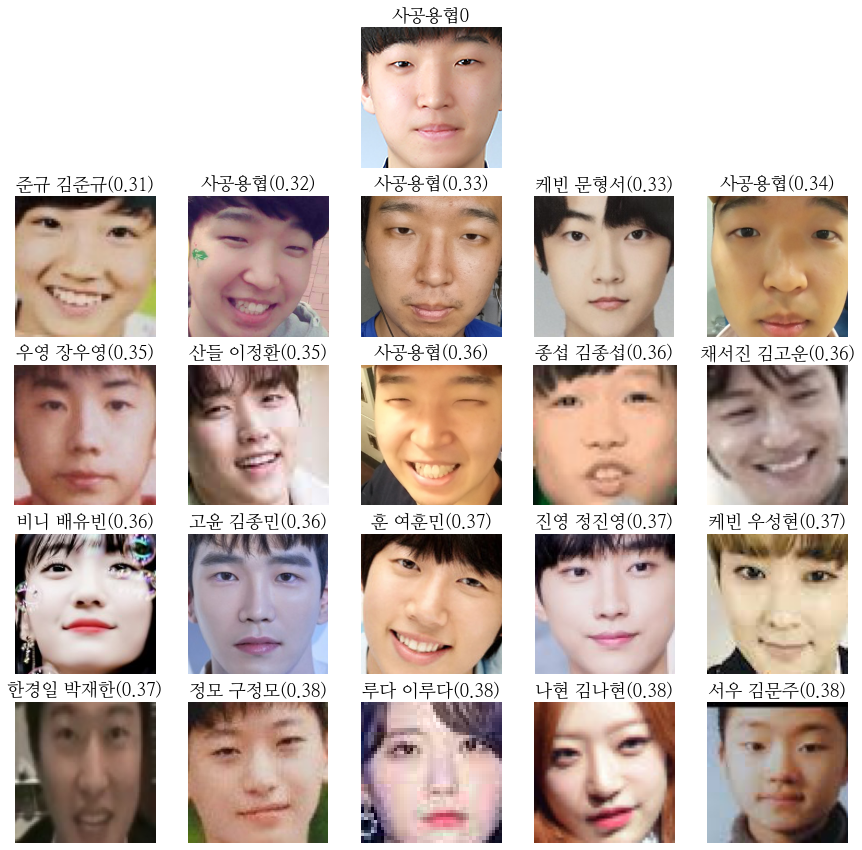

In [83]:
# 파일 이름을 깔끔하게 해주는 함수
def get_korean(name):
    hangul = re.compile('[ ㄱ-ㅣ가-힣]+')
    return hangul.findall(name)[0]
    
result, top_distance = get_nearest_face('사공용협0',embedding_dict, top=20)   # 본인 얼굴과 비슷한 상위 20개 연예인 계산

plt.figure(figsize=(15,15))

plt.subplot(5,5,3)
plt.imshow(cropped_image_dict['사공용협0'])
plt.title('사공용협0', fontproperties=fontprop)
plt.axis('off')

for i, data in enumerate(result):
    name, embedding = data
    image = cropped_image_dict[name]
    name = get_korean(name)               # 파일명 깨끗하게 출력
    plt.subplot(5,5,5+i+1)
    plt.imshow(image)
    plt.title(f'{name}({top_distance[i]:0.2f})', fontproperties=fontprop)
    plt.axis('off')

# tSNE 시각화
실제로 얼마나 떨어져있는지 눈으로 확인
- Similarity 계산 결과가 List형으로 나오기 때문에 DataFrame형태로 변환 필요

> **실제 embedding의 거리와는 차이가 있다는 것을 알수 있다.**

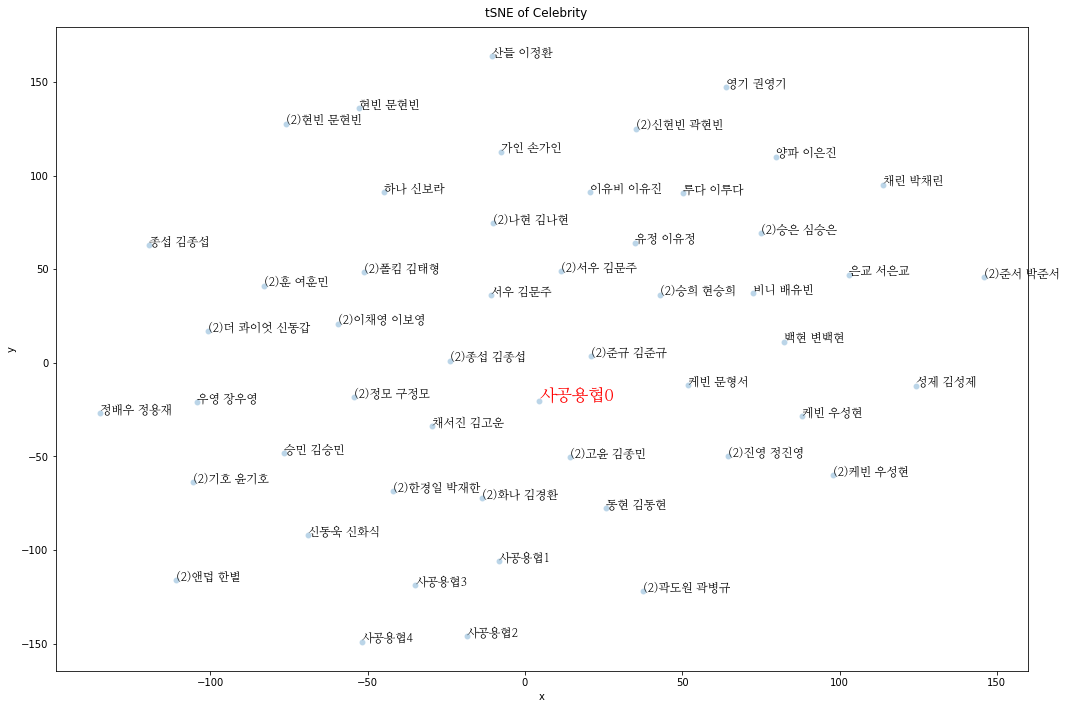

In [134]:
import numpy as np
from sklearn.manifold import TSNE
np.random.seed(50)
               
result, top_distance = get_nearest_face('사공용협0', embedding_dict, top=50)   # 상위 50명의 닮은 연예인 추출

# List형 결과를 DataFrame 형으로 변환
result_dict = dict(result)
result_dict['사공용협0'] = embedding_dict['사공용협0']   # 본인 얼굴(비교한 사진) 추가
name = result_dict.keys()

X = np.stack(list(result_dict.values()), axis=0)   # list(np.array(), np.array()) 꼴로 되어있는 데이터 np.array()로 변경

# tSNE 계산
X_embedded = TSNE(n_components=2).fit_transform(X)
df_subset = pd.DataFrame()
df_subset['name'] = name
df_subset['x'] = X_embedded[:,0]
df_subset['y'] = X_embedded[:,1]

plt.figure(figsize=(15,10))
plt.suptitle('tSNE of Celebrity')
sns.scatterplot(x="x", y="y", palette=sns.color_palette("hls", 10),
                data=df_subset, legend="full", alpha=0.3)

for index, data in df_subset.iterrows():
    if data['name'] == '사공용협0':         # 비교 사진(본인 사진)의 경우 빨간색과 글씨 크기 키우기(한 눈에 보기 위해)
        color = 'red'
        size = 'xx-large'
    else:
        color = 'black'
        size = 'large'
    plt.text(data['x'], data['y'], data['name'], horizontalalignment='left',       # 각 point 옆에 이름 출력
              size=size, color=color, weight='semibold', fontproperties=fontprop)
    
plt.tight_layout()

# 만화 캐릭터 얼굴
인기있는 애니메이션의 등장인물 중 닮은 캐릭터 찾기
- 일곱개의 대죄
- 강철의 연금술사
- 드래곤볼
- 나루토
- 고스트바둑왕
- 이뉴야샤
- 포켓몬스터
- 도라에몽
- 코난
- 슬램덩크
- 짱
- 블리치

# 만화 캐릭터 얼굴 추출
연예인의 경우와 동일하게 진행

In [16]:
folder_list = glob.glob(os.getenv("HOME") + '/aiffel/face_embedding/cartoon/*')

cartoon_cropped_image_dict = {}
for folder in folder_list:
    for image_path in glob.glob(folder + '/*'):
        try:
            name = get_name(image_path)
            image = fr.load_image_file(image_path)
            
            face_locations = fr.face_locations(image)                                       
            top, right, bottom, left = face_locations[0]
            cropped_image = image[top:bottom, left:right]
            cartoon_cropped_image_dict[name] = cropped_image
        except:
            pass
    print(folder.split('/')[-1], 'Completed')

print('All Finished')

슬램덩크 Completed
일곱개의대죄 Completed
만화짱 Completed
강철의연금술사 Completed
드래곤볼 Completed
나루토캐릭터 Completed
고스트바둑왕 Completed
이뉴야샤 Completed
포켓몬스터 Completed
도라에몽 Completed
코난 Completed
블리치 Completed
원피스캐릭터 Completed
All Finished


### 저장

In [17]:
with open('cropped_image_cartoon.pkl', 'wb') as f:
    pickle.dump(cartoon_cropped_image_dict, f)

with open('cropped_image_cartoon.pkl', 'rb') as f:
    cartoon_cropped_image_dict = pickle.load(f)
    
print('Number of images :', len(cartoon_cropped_image_dict))

Number of images : 909


# 만화 캐릭터 얼굴 임베딩

In [18]:
cartoon_embedding_dict = {}
for data in tqdm_notebook(cartoon_cropped_image_dict.items()):        
    name, face = data
    embedding = fr.face_encodings(face)
    if len(embedding) >= 1:
        cartoon_embedding_dict[name] = embedding[0]
    else:
        pass
print('All Finished')

  0%|          | 0/909 [00:00<?, ?it/s]

All Finished


# 임베딩 중복 데이터 제거
위 과정과 동일하게 데이터를 수집하는 과정에서 같은 이미지가 포함

In [19]:
df_embedding = pd.DataFrame(cartoon_embedding_dict).T
df_embedding.drop_duplicates(inplace=True)

cartoon_embedding_dict = df_embedding.T.to_dict(orient='list')
cartoon_embedding_dict = {k : np.array(v) for k, v in cartoon_embedding_dict.items()}

### 저장

In [20]:
with open('cartoon_embedding_full.pkl', 'wb') as f:
    pickle.dump(cartoon_embedding_dict, f)

with open('cartoon_embedding_full.pkl', 'rb') as f:
    cartoon_embedding_dict = pickle.load(f)
    
print('Number of images :', len(cartoon_cropped_image_dict))

Number of images : 909


### 본인사진 추가

In [21]:
image_dir = glob.glob(os.getenv('HOME') + '/aiffel/face_embedding/*.jpg')

for image_path in tqdm_notebook(image_dir):
    name = get_name(image_path)
    image = fr.load_image_file(image_path)
    
    cropped = get_cropped_face(image)
    cartoon_cropped_image_dict[name] = cropped
    
    embedding = fr.face_encodings(cropped)
    cartoon_embedding_dict[name] = embedding[0]
print('All Finished')

  0%|          | 0/5 [00:00<?, ?it/s]

All Finished


# 결과 시각화
과연 나와 닮은 만화 캐릭터는 무엇일까?
- ```clean_name()``` : 각 이미지의 파일명에서 이름만 추출하는 함수
> **각 캐릭터의 이름을 전부 알지 못해서 만화의 제목으로 이름 대체**

In [22]:
# 두 명의 임베딩 거리 측정하는 함수
def get_distance(name1, name2, cartoon_embedding_dict):
    name1_embedding = cartoon_embedding_dict[name1]
    name2_embedding = cartoon_embedding_dict[name2]
    distance = np.linalg.norm(name1_embedding - name2_embedding, ord=2)
    
    return distance

# 한 명의 이름을 먼저 넣고, 나머지 이름을 모두 비교할 수 있도록 도와주는 함수
# 이후에 sorted()를 할 때 key인자로 사용
def sort_key_value(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2, cartoon_embedding_dict)
    
    return get_distance_from_name1

# key인자에 함수를 이용하여 비교하고자 하는 사람과 나머지 사람들을 전부 비교
def get_nearest_face(name, cartoon_embedding_dict, top=5):
    key_value = sort_key_value(name)
    result = sorted(cartoon_embedding_dict.items(), key=lambda x: key_value(x[0]))[1:top+1]
    
    top_distance = [get_distance(name, k, cartoon_embedding_dict) for k, v  in result]
    
    return result, top_distance

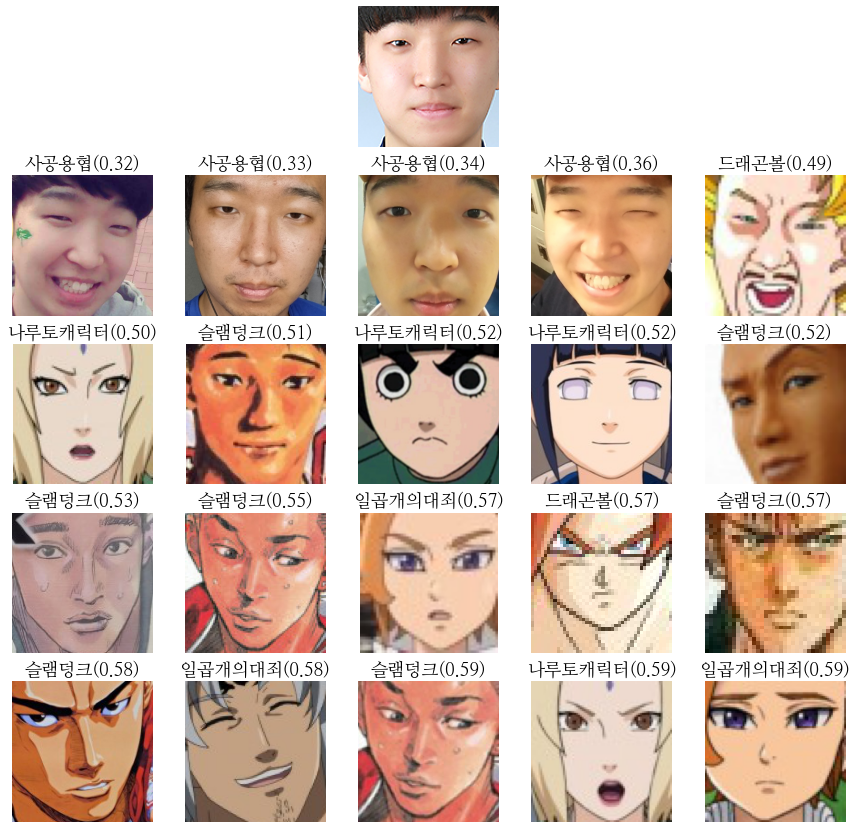

In [23]:
result, top_distance = get_nearest_face('사공용협0', cartoon_embedding_dict, top=20)

plt.figure(figsize=(15,15))
plt.subplot(5,5,3)
plt.imshow(cropped_image_dict['사공용협0'])
plt.axis('off')

for i, data in enumerate(result):
    name, embedding = data
    image = cartoon_cropped_image_dict[name]
    name = re.match('[가-힣]+', name).group()
    plt.subplot(5,5,5+i+1)
    plt.imshow(image)
    plt.title(f'{name}({top_distance[i]:0.2f})', fontproperties=fontprop)
    plt.axis('off')

# 결과 및 고찰
- 연예인의 경우 나름 비슷한 사람의 얼굴이 나왔지만, 만화의 경우 수치에 대한 신빙성이 없음(안 닮음...)
- 이미지를 수집하는 과정에서 화질이 좋고 정확히 정면을 보는 이미지를 구하지 못해서 아쉽다.
- 이 프로젝트를 진행하기 전에는 닮은꼴 찾는 방법이 매우 어렵다고 느꼈는데, 방법이 매우 간단해서 놀랐다.
- 딥러닝을 사용하지 않고도 충분히 이런 기능을 구현할 수 있다는 사실이 매우 신기했다.
- 웹서비스로도 충분히 구현할 수 있다고 생각했고, 실제로 구현해보고 싶다는 생각이 들었다.
- **tSNE**와 실제 Embedding의 거리는 차이가 있다는 것을 **tSNE**시각화를 통해 알 수 있었다.

> **결론은 데이터 과학에서는 데이터가 가장 중요하다는 것을 또 한 번 느꼈다.**